In [36]:
import pandas as pd
import numpy as np
import faiss
import time
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import GridSearchCV, cross_val_score
from catboost import CatBoostClassifier
import warnings

warnings.simplefilter("ignore", UserWarning)

PATH = '/home/maria_grig/projects/master/stock_matching/'

In [2]:
#import torch

#device = torch.device("cuda")

In [3]:
#device

# Load data

## Base

### Base dataset

In [4]:
df_base = pd.read_csv(PATH + 'base.csv', index_col=0)
df_base.head()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083890,11.152912,-64.426760,-118.88089,216.482440,-104.698060,-469.070588,44.348083,120.915344,181.449700,...,-42.808693,38.800827,-151.76218,-74.389090,63.66634,-4.703861,92.933610,115.269190,-112.756640,-60.830353
1-base,-34.562202,13.332763,-69.787610,-166.53348,57.680607,-86.098370,-85.076666,-35.637436,119.718636,195.234190,...,-117.767525,41.100000,-157.82940,-94.446806,68.20211,24.346846,179.937930,116.834000,-84.888941,-59.524610
2-base,-54.233746,6.379371,-29.210136,-133.41383,150.895830,-99.435326,52.554795,62.381706,128.951450,164.381470,...,-76.397800,46.011803,-207.14442,127.325570,65.56618,66.325680,81.073490,116.594154,-1074.464888,-32.527206
3-base,-87.520130,4.037884,-87.803030,-185.06763,76.369540,-58.985165,-383.182845,-33.611237,122.031910,136.233580,...,-70.647940,-6.358921,-147.20105,-37.692750,66.20289,-20.566910,137.206940,117.474100,-1074.464888,-72.915490
4-base,-72.743850,6.522049,43.671265,-140.60803,5.820023,-112.074080,-397.711282,45.182500,122.167180,112.119064,...,-57.199104,56.642403,-159.35184,85.944724,66.76632,-2.505783,65.315285,135.051590,-1074.464888,0.319401


In [5]:
df_base.shape

(2918139, 72)

### Create index

In [6]:
dims = df_base.shape[1]
n_cells = 15 # how many cells
quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)

In [7]:
idx_l2.train(np.ascontiguousarray(df_base.values[:50000, :]).astype('float32'))

idx_l2.add(np.ascontiguousarray(df_base.values).astype('float32'))

In [8]:
base_index = {k: v for k, v in enumerate(df_base.index.to_list())}

#del df_base

# Train

In [9]:
df_train = pd.read_csv(PATH + 'train.csv', index_col=0)
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.93668,187.517490,-87.144930,-347.360606,38.307602,109.085560,30.413513,...,70.107360,-155.80257,-101.965943,65.903790,34.457500,62.642094,134.763600,-415.750254,-25.958572,675816-base
1-query,-87.776370,6.806268,-32.054546,-177.26039,120.803330,-83.810590,-94.572749,-78.433090,124.915900,140.331070,...,4.669178,-151.69771,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092211,-51.276833,366656-base
2-query,-49.979565,3.841486,-116.118590,-180.40198,190.128430,-50.837620,26.943937,-30.447489,125.771164,211.607820,...,78.039764,-169.14620,82.144186,66.008220,18.400496,212.409730,121.931470,-1074.464888,-22.547178,1447819-base
3-query,-47.810562,9.086598,-115.401695,-121.01136,94.652840,-109.255410,-775.150134,79.186520,124.003100,242.650650,...,44.515266,-145.41675,93.990981,64.131350,106.061920,83.178760,118.277725,-1074.464888,-19.902788,1472602-base
4-query,-79.632126,14.442886,-58.903397,-147.05254,57.127068,-16.239529,-321.317964,45.984676,125.941284,103.392670,...,45.028910,-196.09207,-117.626337,66.926220,42.456170,77.621765,92.479930,-1074.464888,-21.149351,717819-base


In [10]:
targets = df_train["Target"]
df_train.drop("Target", axis=1, inplace=True)

In [11]:
start = time.time()
vecs, idx = idx_l2.search(np.ascontiguousarray(df_train.values).astype('float32'), 15)
print('search took {}'.format(time.time() - start))

search took 251.76818466186523


In [12]:
start = time.time()

acc = 0
idx_list = np.zeros(len(targets))
n=0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    #acc += int(target in [base_index[r] for r in el])
    #n  +=1
    if target in [base_index[r] for r in el]:
        idx_list[n] = 1
        acc +=1
    n+=1
        #y_train.append(el)
print('search took {}'.format(time.time() - start))

print('neighbours found: {} %'.format(100 * acc / len(idx)))


search took 0.6480839252471924
neighbours found: 12.655 %


0    0.87345
1    0.12655
Name: proportion, dtype: float64


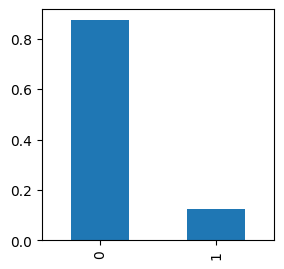

In [21]:
plt.figure(figsize=(3,3))
class_frequency = pd.Series(idx_list.astype(int)).value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar');  

### Predictions & Metrics

In [48]:
scores_list = []

In [44]:
model_lr = LogisticRegression()
scores_lr = cross_val_score(model_lr, df_train.reset_index(drop=True), 
                            pd.Series(idx_list.astype(int)), cv=4, scoring='accuracy')


0.873

In [49]:
score = round(scores_lr.mean(),3)
scores_list.append(score)
score

0.873

In [42]:
model_dt = DecisionTreeClassifier(max_depth=9, min_samples_leaf=5, min_samples_split=6)

scores_dt = cross_val_score(model_dt, df_train.reset_index(drop=True), 
                            pd.Series(idx_list.astype(int)), cv=4, scoring='accuracy')


0.872

In [50]:
score = round(scores_dt.mean(),3)
scores_list.append(score)
score

0.872

In [43]:
model_rf = RandomForestClassifier(n_estimators=25, max_depth=11, min_samples_split=8,min_samples_leaf=1)

scores_rf = cross_val_score(model_rf, df_train.reset_index(drop=True), 
                            pd.Series(idx_list.astype(int)), cv=4, scoring='accuracy')


0.874

In [51]:
score = round(scores_rf.mean(),3)
scores_list.append(score)
score

0.874

In [40]:
model_lgbm = RandomForestClassifier(n_estimators=115, max_depth=10)

scores_lgbm = cross_val_score(model_lgbm, df_train.reset_index(drop=True), 
                            pd.Series(idx_list.astype(int)), cv=4, scoring='accuracy')


NameError: name 'scores_rlgbm' is not defined

In [52]:
score = round(scores_lgbm.mean(),3)
scores_list.append(score)
score

0.873

0.873

In [45]:
model_cb = CatBoostClassifier(verbose=200, iterations=2000, depth=9)

scores_cb = cross_val_score(model_cb, df_train.reset_index(drop=True), 
                            pd.Series(idx_list.astype(int)), cv=4, scoring='accuracy')


Learning rate set to 0.034478
0:	learn: 0.6648431	total: 114ms	remaining: 3m 47s
200:	learn: 0.2769348	total: 12s	remaining: 1m 47s
400:	learn: 0.2456366	total: 23.7s	remaining: 1m 34s
600:	learn: 0.2202627	total: 35.3s	remaining: 1m 22s
800:	learn: 0.1978868	total: 46.9s	remaining: 1m 10s
1000:	learn: 0.1780483	total: 58.4s	remaining: 58.3s
1200:	learn: 0.1609438	total: 1m 9s	remaining: 46.5s
1400:	learn: 0.1454419	total: 1m 21s	remaining: 34.8s
1600:	learn: 0.1317533	total: 1m 32s	remaining: 23.2s
1800:	learn: 0.1197828	total: 1m 44s	remaining: 11.5s
1999:	learn: 0.1086827	total: 1m 56s	remaining: 0us
Learning rate set to 0.034478
0:	learn: 0.6648143	total: 62.5ms	remaining: 2m 4s
200:	learn: 0.2775133	total: 11.7s	remaining: 1m 44s
400:	learn: 0.2460314	total: 23.1s	remaining: 1m 32s
600:	learn: 0.2213990	total: 34.6s	remaining: 1m 20s
800:	learn: 0.1988840	total: 46.1s	remaining: 1m 9s
1000:	learn: 0.1792683	total: 57.7s	remaining: 57.6s
1200:	learn: 0.1626331	total: 1m 9s	remainin

0.88

In [53]:
score = round(scores_cb.mean(),3)
scores_list.append(score)
score

0.88

In [54]:
scores_list

[0.873, 0.872, 0.874, 0.873, 0.88]

In [56]:
metrics ={'accuracy': scores_list}
cols = ['Log Reg','Dec Tree','Rand Forest','LGBM','CatBoost']
pd.DataFrame(data=metrics, index=cols).sort_values(by='accuracy', ascending=False)

,accuracy
CatBoost,0.880
Rand Forest,0.874
Log Reg,0.873
LGBM,0.873
Dec Tree,0.872


## Validation

In [ ]:
df_valid = pd.read_csv(PATH + 'validation.csv', index_col=0)
df_valid.head()

In [ ]:
valid_targets = pd.read_csv(PATH + 'validation_answer.csv', index_col=0)
valid_targets.head()

In [ ]:
X_valid = df_valid.reset_index(drop=True)
y_valid = idx_list_valid

In [ ]:
y_valid_pred = model.predict(X_valid)

In [ ]:
y_valid_pred

In [ ]:
bb